In [1]:
# !pip install --quiet langchain-community 
# !pip install --quiet langchain-experimental langchain-openai 
# !pip install --quiet graphdatascience tiktoken retry neo4j
# !pip install --quiet matplotlib pandas numpy seaborn

## Graph RAG

In [71]:
import os
import pandas as pd
import tiktoken
from langchain_community.graphs import Neo4jGraph
from tqdm import tqdm
import numpy as np
import re

pd.set_option('display.max_columns', None)

In [3]:
os.environ["NEO4J_URI"] = "bolt://localhost:7687"
os.environ["NEO4J_USERNAME"] = "neo4j"
os.environ["NEO4J_PASSWORD"] = "Password@123"
graph = Neo4jGraph()

In [127]:
data = pd.read_csv("flipkart_product.csv", encoding="latin1")
# remove special characters from ProductName
# Using regex to replace all special characters with a space
spl_chars = '[!@#$%^&*()\[\]{};:,./<>?\|`~\-=_+]'
data["ProductName"] = data["ProductName"].apply(lambda x: re.sub(spl_chars, ' ', x))
data["Price"] = data["Price"].apply(lambda x: re.sub(spl_chars, ' ', str(x)))
data["Summary"] = data["Summary"].apply(lambda x: re.sub(spl_chars, ' ', str(x)))
# extract number from price
data["Price"] = data["Price"].apply(lambda x: re.findall(r'\d+', x))
data.head()

,ProductName,Price,Rate,Review,Summary
0,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",5,Super!,Great cooler excellent air flow and for this...
1,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",5,Awesome,Best budget 2 fit cooler Nice cooling
2,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",3,Fair,The quality is good but the power of air is de...
3,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",1,Useless product,Very bad product it's a only a fan
4,Candes 12 L Room Personal Air Cooler ÿ ÿ White...,"[3, 999]",3,Fair,Ok ok product


In [53]:
# data['Match_id'].value_counts().sort_values(ascending=True)
# Match 3495290 has the less number of rows

In [81]:
def get_token_count(text, model='gpt-4o'):
    encoding = tiktoken.encoding_for_model(model)
    num_tokens = len(encoding.encode(text))
    return num_tokens
data['token_count'] = [get_token_count(f"{row['ProductName']} {row['Summary']}") for i, row in data.iterrows()]

<Axes: title={'center': 'Token Count Distribution'}, xlabel='Token Count', ylabel='Frequency'>

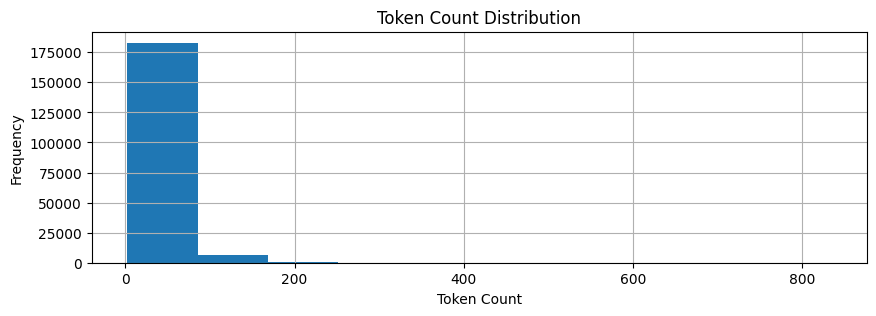

In [82]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 3))
plt.title("Token Count Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
data['token_count'].hist()

Most of the reviews have less than 100 words, hence further splitting is not required.

In [83]:
from langchain_experimental.graph_transformers import LLMGraphTransformer
from langchain_community.graphs.graph_document import GraphDocument
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_openai import AzureChatOpenAI

os.environ["AZURE_OPENAI_API_KEY"] = "533894d8f28d4f238f10c0a51a46789e"
os.environ["AZURE_OPENAI_ENDPOINT"] = "https://sriks-openai.openai.azure.com/"
os.environ["AZURE_OPENAI_API_VERSION"] = "2024-05-01-preview"
os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"] = "gpt-4o"

llm = AzureChatOpenAI(
    openai_api_version=os.environ["AZURE_OPENAI_API_VERSION"],
    azure_deployment=os.environ["AZURE_OPENAI_CHAT_DEPLOYMENT"],
)

llm_transformer = LLMGraphTransformer(
    llm=llm,
    node_properties=["description"],
    relationship_properties=["description"]
)     

Extract the entities, relationships from text and create graph

In [130]:
import random
random.seed(42)
# take 25 random rows
ids = random.sample(range(1, len(data)-1), 25)
data = data.iloc[ids]
data.head()

,ProductName,Price,Rate,Review,Summary
26794,Home Sizzler 153 cm 5 02 ft Polyester Room D...,[299],5,Brilliant,Superb
177393,AGARO Regal Hand held Vacuum CleanerÂ Â Black,"[1, 599]",1,Don't waste your money,Worst product In 15 min all wires burns
6557,Cosito 144 TC Cotton Double Floral Flat Bedshe...,[339],4,Very Good,Very good
132476,Hold up Triangle Shape Mobile Holder For Table...,[136],5,Simply awesome,Very Nice Stands with Cheaper rate
57315,Men Black Sandal,[299],5,Nan,Good


In [131]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

graph_documents = []
# Convert each row to a Graph Document
# this will take some time 50 rows = 50*3 = 150 requests
# this may fail if token limit is reached
with ThreadPoolExecutor(max_workers=2) as executor:
    futures = [executor.submit(llm_transformer.convert_to_graph_documents, [Document(page_content=f"""You are a data processing assistant, your task is to extract entities, relationships and their labels from product reviews. 
                                                                                     {row['ProductName'], row['Price'], row['Rate']} Review:{row['Review']} Summary:{row['Summary']}. 
                                                                                     """)]) for i, row in data.iterrows()]
    for future in tqdm(as_completed(futures), total=len(futures), desc="Converting to Graph Documents"):
        graph_documents.extend(future.result())
        

Converting to Graph Documents: 100%|██████████| 25/25 [03:23<00:00,  8.14s/it]


In [132]:
# creating graph docs will take time hence saving it to pickle file to load from it in future
# save graph docs to pickle file
import pickle
with open('graph_documents.pkl', 'wb') as f:
    pickle.dump(graph_documents, f)

In [133]:
graph_documents = pickle.load(open('graph_documents.pkl', 'rb'))

In [134]:
graph.add_graph_documents(
    graph_documents,
    baseEntityLabel=True,
    include_source=True
)

Generate embeddings for the extracted entities

In [135]:

from langchain_community.vectorstores import Neo4jVector
from langchain_openai import AzureOpenAIEmbeddings

# Create a vector store from the existing graph
vector = Neo4jVector.from_existing_graph(
        AzureOpenAIEmbeddings(),
        node_label='__Entity__',
        text_node_properties=['id', 'description'],
        embedding_node_property='embedding'
)

In [136]:
from graphdatascience import GraphDataScience

# Create a GraphDataScience instance
# GDS plugin must be installed in the Neo4j instance
gds = GraphDataScience(
    os.environ["NEO4J_URI"],
    auth=(os.environ["NEO4J_USERNAME"], os.environ["NEO4J_PASSWORD"])
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('serverLocation' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('advertisedListenAddress' returned by 'gds.debug.arrow' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.debug.arrow()'


In [139]:
similrity_threshold = 0.95
gds.graph.drop("entities")
# exclude the score property from the graph
G, result = gds.graph.project(
    "entities", 
    "__Entity__",
    "*",
    nodeProperties=["embedding"],
    )   

# mutating the graph to add similar relationships

result = gds.knn.mutate(
    G,
    nodeProperties=["embedding"],
    nodeLabels = ["__Entity__"],
    mutateRelationshipType="SIMILAR",
    mutateProperty="score",
    similarityCutoff=similrity_threshold,
)
result.similarityDistribution    
print(result)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


ranIterations                                                             6
nodePairsConsidered                                                   20671
didConverge                                                            True
preProcessingMillis                                                       0
computeMillis                                                           132
mutateMillis                                                             23
postProcessingMillis                                                      0
nodesCompared                                                            73
relationshipsWritten                                                    265
similarityDistribution    {'min': 0.9500045776367188, 'p5': 0.9508438110...
configuration             {'mutateProperty': 'score', 'jobId': 'c62921cb...
Name: 0, dtype: object


In [140]:
# writing the graph back to the database
result = gds.knn.write(
    G,
    nodeProperties=["embedding"],
    writeRelationshipType="SIMILAR",
    writeProperty="score",
    similarityCutoff=similrity_threshold,
)
print(f"Number of relationships created: {result.relationshipsWritten}")
print(result)

Number of relationships created: 265
ranIterations                                                             4
didConverge                                                            True
nodePairsConsidered                                                   18861
preProcessingMillis                                                       0
computeMillis                                                            48
writeMillis                                                              10
postProcessingMillis                                                      0
nodesCompared                                                            73
relationshipsWritten                                                    265
similarityDistribution    {'min': 0.9500045776367188, 'p5': 0.9508438110...
configuration             {'writeProperty': 'score', 'writeRelationshipT...
Name: 0, dtype: object


In [141]:
# get nodes with relationtype as SIMILAR
query = """
MATCH (n:__Entity__)-[r:SIMILAR]-(m:__Entity__)
RETURN n.id as node1, m.id as node2, r.score as score
"""
result = pd.DataFrame.from_records(gds.run_cypher(query))
# exclude numeric types from node 1 and 2
result = result[~result['node1'].str.contains(r'\d')]
result.head()

C:\Users\vism\AppData\Local\Temp\ipykernel_33320\2281118004.py:6: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  result = pd.DataFrame.from_records(gds.run_cypher(query))


,node1,node2,score
0,Best In The Market!,Must Buy!,0.954885
1,Best In The Market!,Must Buy!,0.954885
2,Great Product,Awesome Product As Usual,0.969401
3,Great Product,Awesome Product As Usual,0.969401
4,Useless Product,Awesome Product As Usual,0.954369


Find similar entities by Levenshtein distance

In [148]:
import Levenshtein

edit_distance_threshold = 4
query = """
MATCH (n:__Entity__)
RETURN n.id as id, n.wcc as wcc
"""
entities_df = pd.DataFrame.from_records(graph.query(query))
print(f"Number of entities: {entities_df.shape[0]}")
edit_distances = pd.crosstab(entities_df['id'], entities_df['id'])
# fill values with edit distance between column and row names
for i in edit_distances.columns:
    for j in edit_distances.index:
        if len(i) > 4 and len(j) > 4:
            # if i or j has "innings" in it, skip
            edit_distances.loc[j, i] = Levenshtein.distance(i, j)
# find edit distances below threshold and greater than 0
edit_distances = edit_distances[(edit_distances < edit_distance_threshold)]
# create a dictionary of similar entities
edit_distances = edit_distances[edit_distances > 1].stack().to_dict()
edit_distances

Number of entities: 73


{('Review', 'Review_1'): 2.0,
 ('Review_1', 'Review'): 2.0,
 ('Summary', 'Summary_1'): 2.0,
 ('Summary_1', 'Summary'): 2.0}

Merge Entities with low edit distance

In [147]:
# merge entities found in edit distances and write to graph
for key, value in edit_distances.items():
    query = f"""
    MATCH (n:__Entity__{{id:'{key[0]}'}})
    MATCH (m:__Entity__{{id:'{key[1]}'}})
    MERGE (n)-[r:SIMILAR{{score:{value}}}]->(m)
    """
    result = graph.query(query)
    print(result)

In [111]:
G.drop()

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $failIfMissing)'


graphName                                                         entities
database                                                             neo4j
databaseLocation                                                     local
memoryUsage                                                               
sizeInBytes                                                             -1
nodeCount                                                               29
relationshipCount                                                      147
configuration            {'relationshipProjection': {'__ALL__': {'aggre...
density                                                           0.181034
creationTime                           2024-07-16T05:38:25.068382600+00:00
modificationTime                       2024-07-16T05:38:25.254583900+00:00
schema                   {'graphProperties': {}, 'nodes': {'__Entity__'...
schemaWithOrientation    {'graphProperties': {}, 'nodes': {'__Entity__'...
Name: 0, dtype: object

## Identify Graph communities and enhance the knowledge using LLM

In [112]:
# # Project the graph to create a community graph
gds.graph.drop("communities")
G, result = gds.graph.project(
    "communities",  #  Graph name
    "__Entity__",  #  Node projection
    "*",
    nodeProperties=["embedding"],
)

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.FeatureDeprecationWarning} {category: DEPRECATION} {title: This feature is deprecated and will be removed in future versions.} {description: The query used a deprecated field from a procedure. ('schema' returned by 'gds.graph.drop' is deprecated.)} {position: line: 1, column: 1, offset: 0} for query: 'CALL gds.graph.drop($graph_name, $fail_if_missing, $db_name)'


In [113]:
gds.wcc.stats(G)

componentCount                                                           2
componentDistribution    {'min': 8, 'p5': 8, 'max': 21, 'p999': 21, 'p9...
postProcessingMillis                                                     4
preProcessingMillis                                                      0
computeMillis                                                            3
configuration            {'jobId': '9d77bb3d-acf0-460d-9880-05c21d458df...
Name: 0, dtype: object

In [114]:
gds.wcc.mutate(
    G,
    mutateProperty="componentId",
)

mutateMillis                                                             0
nodePropertiesWritten                                                   29
componentCount                                                           2
componentDistribution    {'min': 8, 'p5': 8, 'max': 21, 'p999': 21, 'p9...
postProcessingMillis                                                     2
preProcessingMillis                                                      0
computeMillis                                                            8
configuration            {'mutateProperty': 'componentId', 'jobId': '0c...
Name: 0, dtype: object

In [115]:
query = """
    CALL gds.graph.nodeProperties.stream('communities', 'componentId')
    YIELD nodeId, propertyValue
    WITH gds.util.asNode(nodeId).id AS node, propertyValue AS componentId
    WITH componentId, collect(node) AS subgroups
    WITH componentId, subgroups, size(subgroups) AS componentSize
    RETURN componentId, componentSize, subgroups
    ORDER BY componentSize DESC"""
components = gds.run_cypher(query)
components

,componentId,componentSize,subgroups
0,0,21,"[379, 5, Fabulous!, Cosito 144 Tc Cotton Doubl..."
1,3,8,[Cello Pack Of 18 Opalware Cello Dazzle Lush F...


In [116]:
largest_component = components["componentId"][0]
print(f"The largest component has the id {largest_component} with {components['componentSize'][0]} subreddits.")

The largest component has the id 0 with 21 subreddits.
